# Imports

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import tifffile as tiff
from skimage.transform import resize
from pathlib import Path
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Configuration

In [13]:
IMG_SIZE = (64, 64)
NUM_CLASSES = 10

CLASSES = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
    'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
    'River', 'SeaLake'
]

SPECTRAL_BANDS = [
    'Coastal Aerosol', 'Blue', 'Green', 'Red', 'Red Edge 1',
    'Red Edge 2', 'Red Edge 3', 'NIR', 'Red Edge 4',
    'Water Vapor', 'SWIR Cirrus', 'SWIR 1', 'SWIR 2'
]


print("Config Setup completed...")

Config Setup completed...


# Download data from kaggle

In [14]:
dataset_path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Dataset downloaded to:", dataset_path)

Using Colab cache for faster access to the 'eurosat-dataset' dataset.
Dataset downloaded to: /kaggle/input/eurosat-dataset


# Data Loading....


In [16]:
def load_satellite_data(dataset_dir, img_size=IMG_SIZE):

    print("Loading Data...")

    data = []
    labels = []
    class_folders = sorted(os.listdir(dataset_dir))

    for class_name in class_folders:
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue


        for file_name in os.listdir(class_path):
            img_path = os.path.join(class_path, file_name)
            try:
                # Read 13-band images
                img = tiff.imread(img_path)
                # Ensure image contains 13 band
                if img.shape[-1] != 13:
                    print(f"⚠️ Skipping {img_path}: unexpected band count {img.shape[-1]}")
                    continue

                img = resize(img, (img_size[0], img_size[1], 13),
                             preserve_range=True,
                             anti_aliasing=True)

                # Normalize values 0 => 1
                img = img.astype(np.float32)
                img /= img.max()

                data.append(img)
                labels.append(class_name)

            except Exception as e:
                print(f"⚠️ Skipping {img_path}: {e}")

    X = np.array(data)
    Y = np.array(labels)
    return X, Y

# Load data
# DATASET_PATH ="/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSATallBands"
DATASET_PATH ="/kaggle/input/eurosat-dataset/EuroSATallBands"

X, Y = load_satellite_data(DATASET_PATH)

print(f"\n{len(X)} images loaded successfully.")
print(f"Data shape: {X.shape}")
print(f"Classes found: {sorted(CLASSES)}")


Loading Data...

 27597 images loaded successfully.
Data shape: (27597, 64, 64, 13)
Classes found: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


# Data Exploration

## BASIC DATA EXPLORATION ##
['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']
[3000 3000 3000 2500 2500 2000 2500 3000 2500 3597]

Class Distribution:
AnnualCrop: 3000 samples
Forest: 3000 samples
HerbaceousVegetation: 3000 samples
Highway: 2500 samples
Industrial: 2500 samples
Pasture: 2000 samples
PermanentCrop: 2500 samples
Residential: 3000 samples
River: 2500 samples
SeaLake: 3597 samples


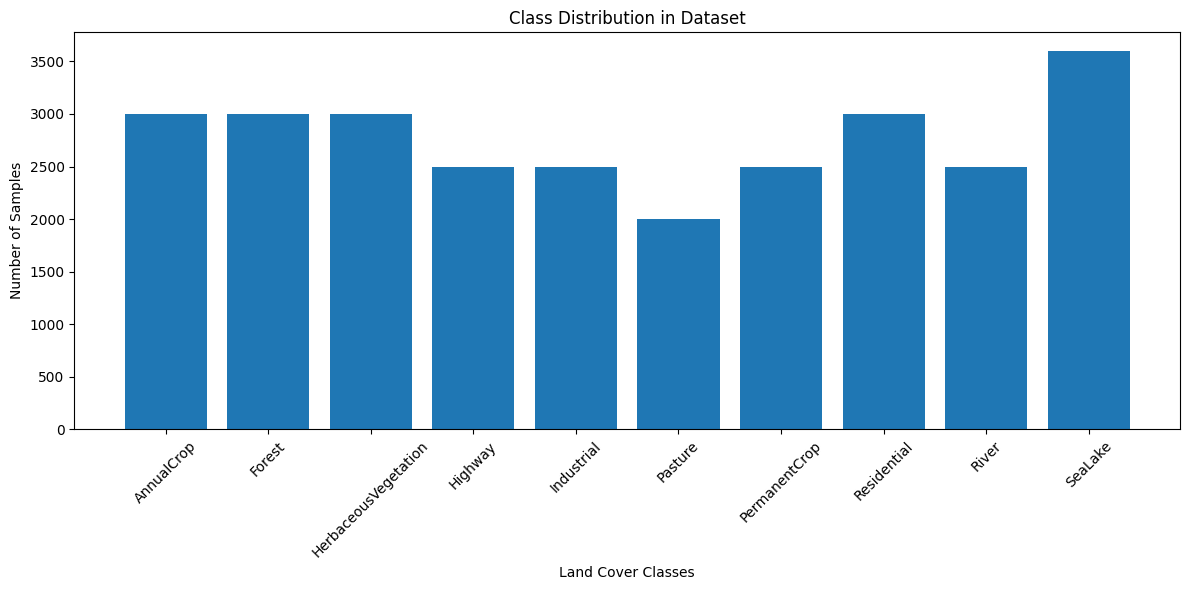

In [20]:
print("## BASIC DATA EXPLORATION ##")

unique_classes, counts = np.unique(Y, return_counts=True)
# print(unique_classes)
# print(counts)
class_distribution = dict(zip(unique_classes, counts))

print("\nClass Distribution:")
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count} samples")


plt.figure(figsize=(12, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Distribution in Dataset')
plt.xlabel('Land Cover Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# SPECTRAL ANALYSIS

## SPECTRAL ANALYSIS ##


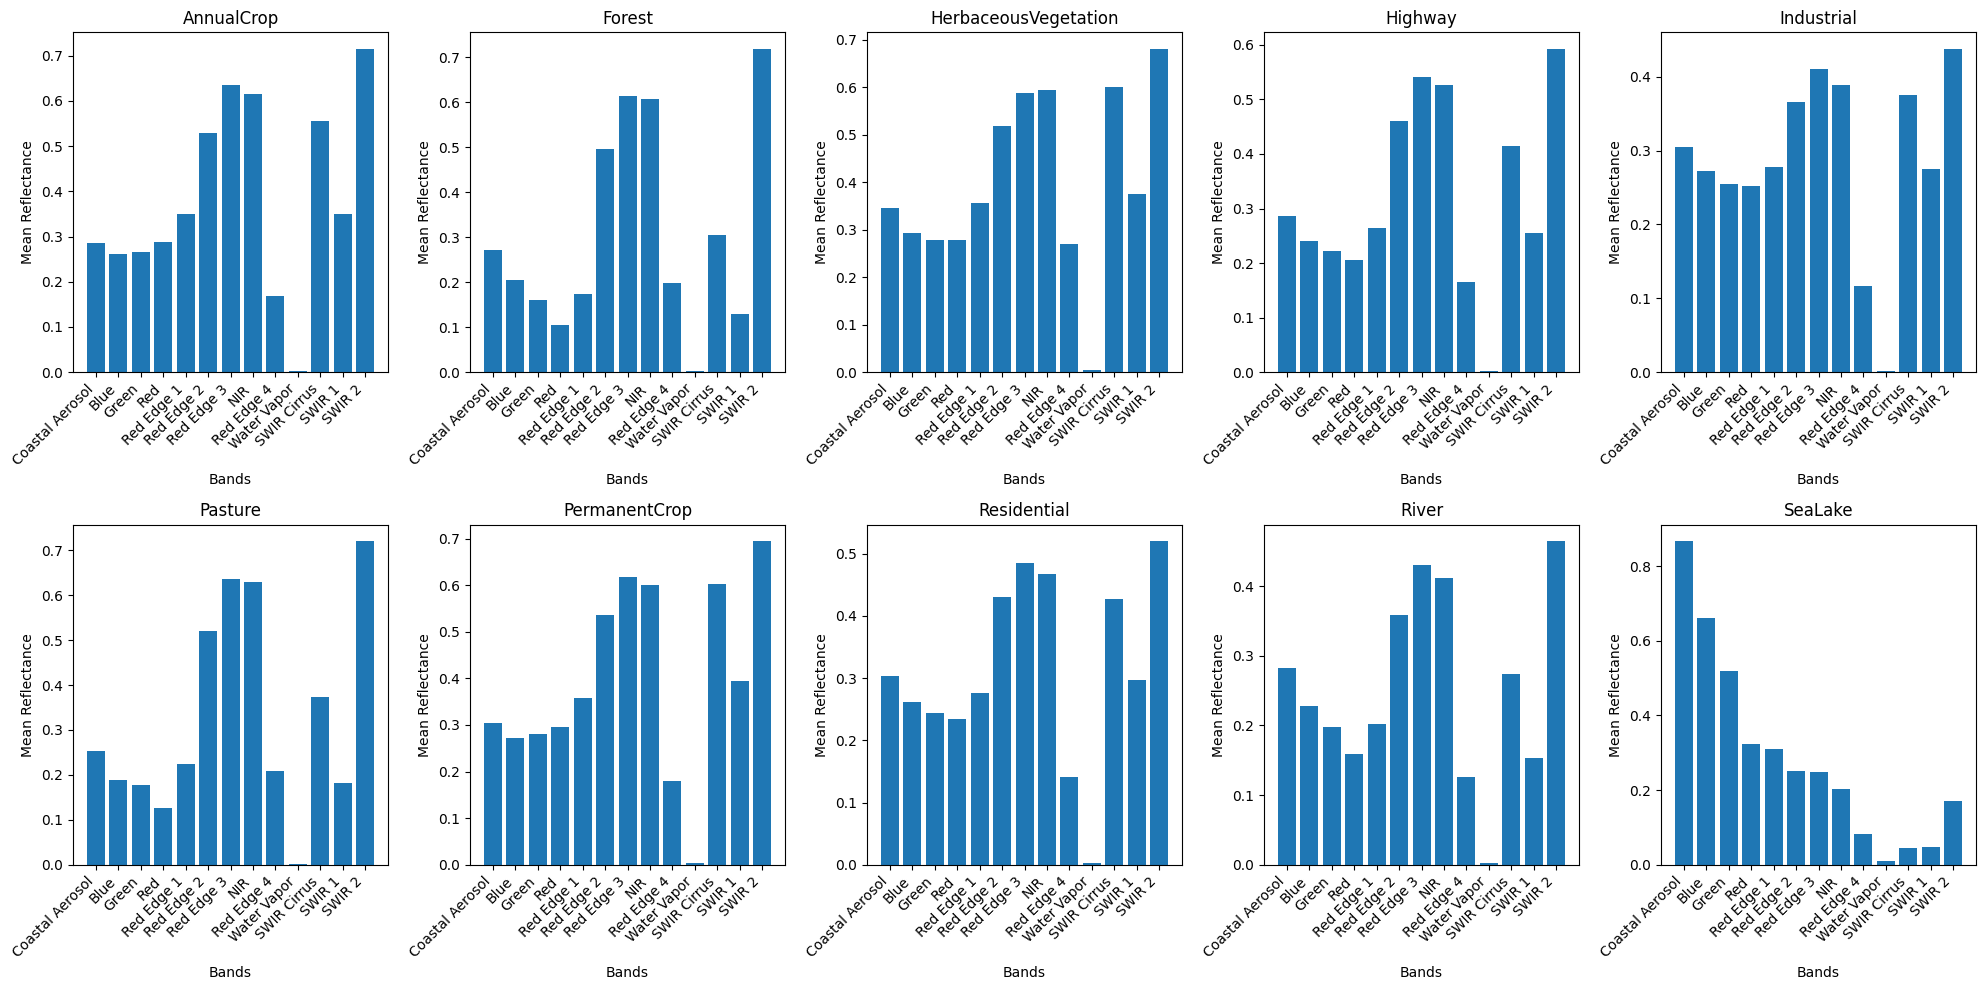

In [27]:
print("## SPECTRAL ANALYSIS ##")

def plot_spectral_bands(data, labels):

    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.ravel()  # flatten 2D array to 1d
    for i, class_name in enumerate(CLASSES):
        class_indices = np.where(labels == class_name)[0]

        # compute mean spectrum for this class
        mean_spectrum = np.mean(data[class_indices], axis=(0,1,2))

        axes[i].bar(range(len(SPECTRAL_BANDS)), mean_spectrum)
        axes[i].set_xticks(range(len(SPECTRAL_BANDS)))
        axes[i].set_xticklabels(SPECTRAL_BANDS, rotation=45, ha='right')
        axes[i].set_title(class_name)
        axes[i].set_ylabel("Mean Reflectance")
        axes[i].set_xlabel("Bands")

    plt.tight_layout()
    plt.show()


plot_spectral_bands(X, Y)

# Sample Images Visualization

## SAMPLE IMAGES VISUALIZATION ##


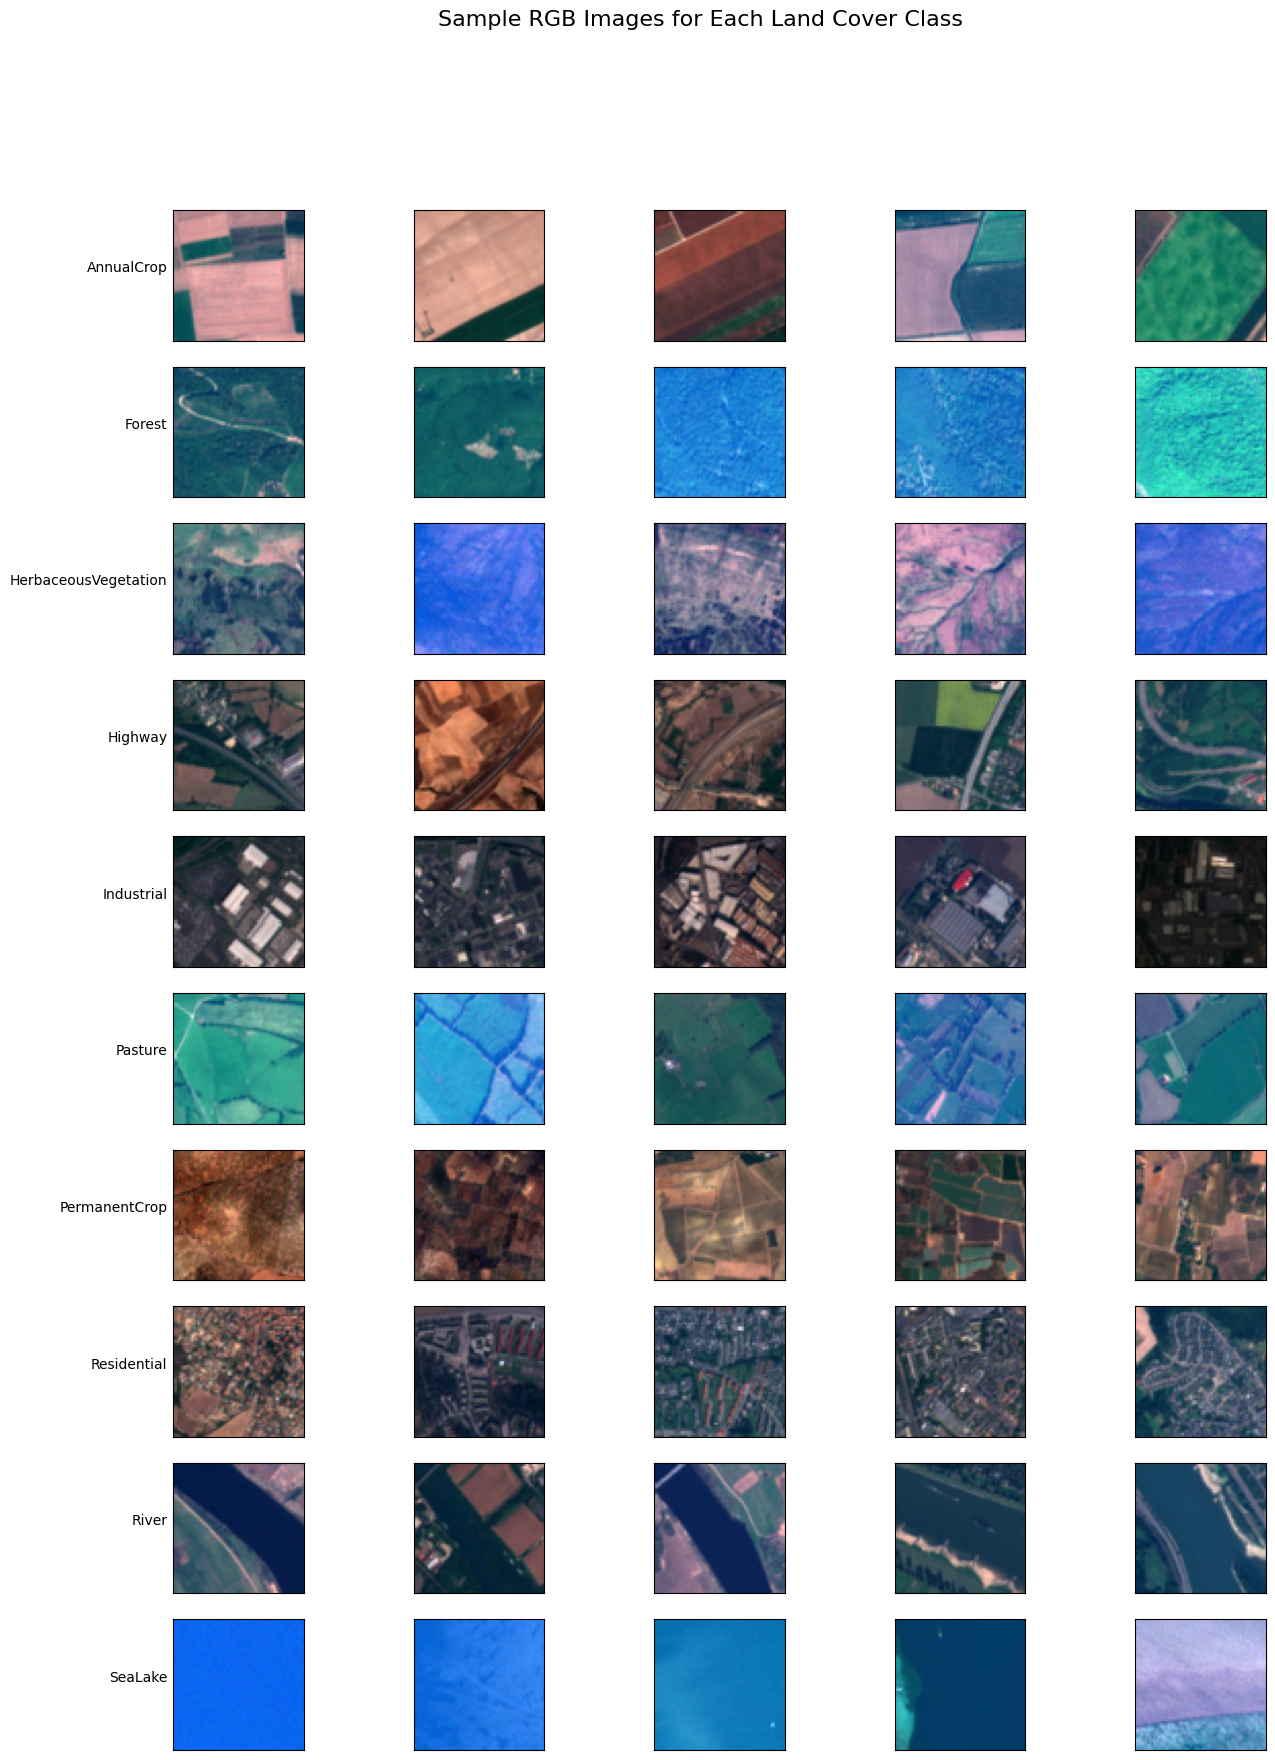

In [ ]:
print("## SAMPLE IMAGES VISUALIZATION ##")

def plot_sample_images(data, labels, n_samples=5):
    """Plot sample RGB images from each class"""
    # Use bands 3,2,1 for RGB (Red, Green, Blue)
    rgb_indices = [3,2,1]

    fig, axes = plt.subplots(len(CLASSES), n_samples, figsize=(15,20))

    for i, class_name in enumerate(CLASSES):
        class_indices = np.where(labels == class_name)[0][:n_samples]

        for j, idx in enumerate(class_indices):
            rgb_image = data[idx][:, :, rgb_indices]

            rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

            axes[i, j].imshow(rgb_image)
            if j == 0:
                axes[i, j].set_ylabel(class_name, rotation=0, ha='right')
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    plt.suptitle('Sample RGB Images for Each Land Cover Class', fontsize=16)
    # plt.tight_layout()
    plt.show()

plot_sample_images(X, Y)